In [1]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping


In [2]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [4]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.jpg'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

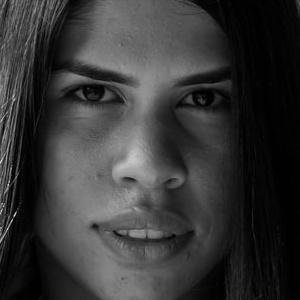

In [5]:
real_image_path = '/content/drive/MyDrive/dta/real/real_1.jpg'
Image.open(real_image_path)

# New Section

In [3]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [6]:
import sys
sys.path.insert(0,'/content/drive/My Drive/dta')

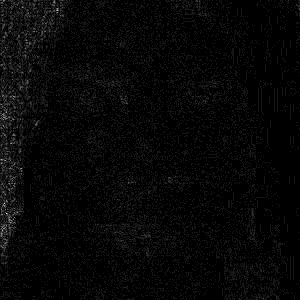

In [7]:
convert_to_ela_image(real_image_path, 90)

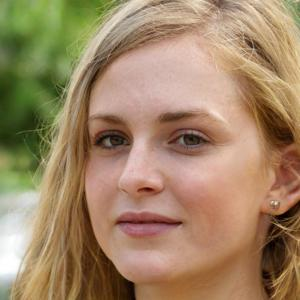

In [8]:
fake_image_path = '/content/drive/MyDrive/dta/fake/fake_10.jpg'
Image.open(fake_image_path)

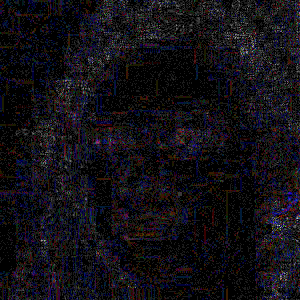

In [9]:
convert_to_ela_image(fake_image_path, 90)

In [10]:
image_size = (128, 128)

In [11]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() /255.0

In [12]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [13]:
import random
path = '/content/drive/MyDrive/dta/real'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 500 images
589 589


In [14]:
path = '/content/drive/MyDrive/dta/fake'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X = np.append(X, prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')
print(len(X), len(Y))

Processing 1000 images
63848448 1299


In [15]:
import keras
from keras.utils import to_categorical
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

1039 1039
260 260


In [17]:
def build_model():
    model = keras.Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [18]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

In [19]:
epochs = 35
batch_size = 32


In [20]:
init_lr = 1e-4
optimizer = Adam(learning_rate=init_lr, decay=init_lr / epochs)

In [21]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0.05,
                              patience = 20,
                              verbose = 0,
                              mode = 'auto')

In [ ]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/35
33/33 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

33/33 [==============================] - 129s 4s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0088 - val_accuracy: 0.9962
Epoch 2/35
33/33 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

33/33 [==============================] - 106s 3s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 3/35
33/33 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

33/33 [==============================] - 101s 3s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 4/35
33/33 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9990

33/33 [==============================] - 105s 3s/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0159 - val_accuracy: 0.9923
Epoch 5/35
33/33 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

33/33 [==============================] - 105s 3s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0116 - val_accuracy: 0.9923
Epoch 6/35
33/33 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

33/33 [==============================] - 101s 3s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 0.9962
Epoch 7/35
33/33 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9990

33/33 [==============================] - 108s 3s/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 8/35
33/33 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9990

33/33 [==============================] - 100s 3s/step - loss: 0.0061 - accuracy: 0.9990 - val_loss: 0.0124 - val_accuracy: 0.9962
Epoch 9/35
33/33 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

33/33 [==============================] - 107s 3s/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 10/35
33/33 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

33/33 [==============================] - 104s 3s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0110 - val_accuracy: 0.9923
Epoch 11/35
33/33 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

33/33 [==============================] - 100s 3s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 12/35
33/33 [==============================] - ETA: 0s - loss: 9.1247e-04 - accuracy: 1.0000

33/33 [==============================] - 106s 3s/step - loss: 9.1247e-04 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 0.9962
Epoch 13/35
33/33 [==============================] - ETA: 0s - loss: 5.7884e-04 - accuracy: 1.0000

33/33 [==============================] - 106s 3s/step - loss: 5.7884e-04 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 14/35
19/33 [================>.............] - ETA: 40s - loss: 6.0973e-04 - accuracy: 1.0000

In [ ]:
model.save('Forgery.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


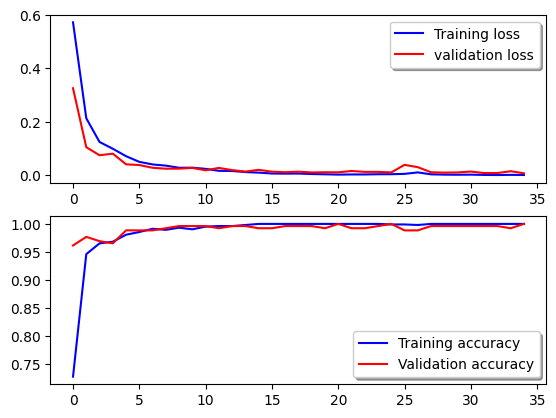

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

9/9 [==============================] - 10s 1s/step


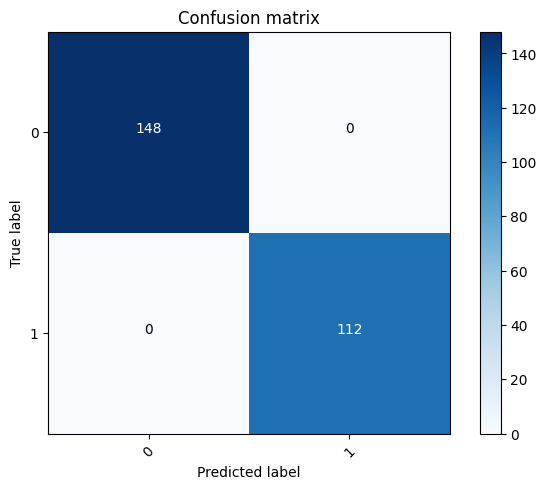

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [ ]:
class_names = ['fake', 'real']

In [ ]:
real_image_path = '/content/drive/MyDrive/dta/fakee.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 156ms/step
Class: real Confidence: 100.00
